# Analysis experiments
This notebook contains all the experiments regarding the analysis component of the thesis. This notebook is subdivided in the following components:

0. Helper Functions
1. Which has a greater impact on the performance: changing tasks at the beginning of the order or changing tasks towards the end of the order?
2. In which settings does task order affect the performance?
3. Is the effect of task order caused by general patterns or very specific interactions between consecutive tasks?
4. Do different continual learning methods benefit from the same task orders?
5. What characterizes task orders that lead to high performance?

## 0. Helper functions

In [1]:
# Config
datasets = ["CIFAR10", "CIFAR10-random", "M2I"]
dataset_to_name = {"CIFAR10": "CIFAR10-I", "CIFAR10-random": "CIFAR10-II", "M2I": "M2I"}
strategies = ["ewc", "lwf", "replay", "agem", "mir", "gss", "cope"]
strategy_to_name = {"ewc": "EWC", "lwf": "LwF", "replay": "ER", "agem": "A-GEM", "mir" : "MIR", "gss": "GSS", "cope": "CoPE"}

regularization_based_strategies = ["ewc", "lwf"]
replay_based_strategies = ["replay", "mir", "gss", "cope"]

In [2]:
import json
import pandas as pd
import ast
import numpy as np
from scipy.stats import t, spearmanr
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

def load_oracle_results(dataset, strategy, metric="accuracy"):
    """ 
    Load and return the results of the oracle experiment for specified setting

    Args:
        dataset: the name of the dataset
        strategy: the continual learning strategy
        metric: which metric to return the results of, any of: "accuracy", "accuracy_std", "forgetting", "forgetting_std", "accuracy_per_task"ArithmeticError
    
    Returns:
        A dictionary containing the result for the specified setting
    """
    with open(
                f"logs/oracle_comparison/strategy-{strategy}-dataset-{dataset}-{metric}.json",
                "r",
            ) as file:
        return json.load(file)

def get_top(dictionary, x, descending=True):
    # Sort the dictionary items based on values in descending order
    sorted_items = sorted(
        dictionary.items(), key=lambda item: item[1], reverse=descending
    )

    # Get the keys of the top x items
    top_keys = [item[0] for item in sorted_items[:x]]
    top_values = [item[1] for item in sorted_items[:x]]
    return top_keys, top_values

def get_rank(dictionary, key, descending=True):
    """
    Function to return the rank of item "key" in dictionary "dictionary"

    Args:
    -  dictionary: The dictionary storing the score for each key
    -  key: The key of which we are interested in the rank
    -  descending: Whether or not to sort the values descendingly

    Returns:
    -  rank: the rank of the key (rank 1 is best)
    """
    # Sort the dictionary items based on values in descending order
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=descending)

    # Find the index of the key in the sorted list
    try:
        rank = sorted_items.index((key, dictionary[key])) + 1
        return rank
    except ValueError:
        # Handle the case where the key is not found in the dictionary
        return None
    
def convert_to_ddof_1(std_ddof_0, sample_size=3):
    """
    Convert the population std to sample std, using the information about the sample size
    """
    var = std_ddof_0**2
    var = var * sample_size
    var_ddof_1 = var / (sample_size - 1)
    return np.sqrt(var_ddof_1)

def one_sided_t_test(mean1, mean2, std1, std2, n=3):
    """ 
    Perform a one-sided independent t-test given mean, sample std and sample_size
    """
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    t_statistic = (mean1 - mean2) / (pooled_std * np.sqrt(2/n))
    p_value = 1-t.cdf(t_statistic, n-1)
    return t_statistic, p_value

#Define a function to format numbers in scientific notation with rounding
def scientific_round(x):
    return '{:.2e}'.format(x)

def spearman_footrule_distance(permutation1, permutation2):
    # Check if the input permutations have the same length
    if len(permutation1) != len(permutation2):
        raise ValueError("Permutations must have the same length")

    distance = 0

    for idx1, element in enumerate(permutation1):
        idx2 = permutation2.index(element)
        distance += abs(idx1 - idx2)
    return distance

def rank_distance_correlation(
    ordered_permutations
):
    rank_differences = []
    distances = []
    for rank1, permutation1 in enumerate(ordered_permutations):
        for rank_diff, permutation2 in enumerate(ordered_permutations[rank1:]):
            # We do not include the 0 distance between two permutations, since this biases the correlation
            # the same permutation will always have the same rank
            if permutation1 == permutation2:
                pass
            else:
                rank_differences.append(rank_diff)
                distances.append(
                    spearman_footrule_distance(
                        list(ast.literal_eval(permutation1)),
                        list(ast.literal_eval(permutation2)),
                    )
                )
    # Calculate spearman correlation coefficient and p-value
    return spearmanr(rank_differences, distances)

def average_score_permutations(dataset, strategies):
    """ 
    Compute and return 2 dataframes, one storing the average accuracy of each permutation over the strategies,
    one containing the average rank of each permutation over the specified strategies
    """
    results = defaultdict(list)
    ranks = defaultdict(list)
    for strategy in strategies:
        accuracy_scores = load_oracle_results(dataset, strategy, "accuracy")
        for key in accuracy_scores.keys():
            results[key].append(accuracy_scores[key])
            ranks[key].append(get_rank(accuracy_scores, key))

    df_results = pd.DataFrame(results).transpose()
    df_results.columns = strategies

    row_mean = df_results.mean(axis=1)

    df_results["Mean Accuracy"] = row_mean

    df_results_sorted = df_results.sort_values(by="Mean Accuracy", ascending=False)

    df_ranks = pd.DataFrame(ranks).transpose()
    df_ranks.columns = strategies

    row_mean = df_ranks.mean(axis=1)

    df_ranks["Mean Accuracy Rank"] = row_mean

    df_ranks_sorted = df_ranks.sort_values(by="Mean Accuracy Rank", ascending=True)
    return df_results_sorted, df_ranks_sorted

def distance_between_elements(lst, elem1, elem2):
    if elem1 not in lst or elem2 not in lst:
        return None  # One or both elements not found in the list

    index1 = lst.index(elem1)
    index2 = lst.index(elem2)

    distance = abs(index1 - index2)
    return distance


def load_results_performance_over_sequence(dataset, strategy, classification="best", memory_size=1000):
    """
    If classification is best we load the best ordering, if classification is worst we load the worst ordering.
    """
    if classification not in ["best", "worst", "random"]:
        raise Exception("incorrect classification")
    if memory_size == 1000:
        with open(f"logs/performance_over_sequence/{dataset}-{strategy}-{classification}.json") as f:
            return json.load(f)
    else:
        with open(f"logs/performance_over_sequence/{dataset}-{strategy}-{memory_size}-{classification}.json") as f:
            return json.load(f)

## 1. Which has a greater impact on the performance: changing tasks at the beginning of the order or changing tasks towards the end of the order?

The results of the task position importance can be found under results/analysis/task_position_importance

In [3]:
for dataset in datasets:
    data = []
    for strategy in strategies:
        result_dict = load_oracle_results(dataset, strategy, metric="accuracy")
        orderings = [ast.literal_eval(ordering) for ordering in result_dict.keys()]
        values = list(result_dict.values())

        strategy_dict = {"Strategy": strategy}
        position_std = []
        # For every position
        for position in range(len(orderings[0])):
            position_task_average_performance = []
            # For every task
            for task_id in range(len(orderings[0])):
                position_task_accuracies = []
                # for every ordering
                for i, ordering in enumerate(orderings):
                    # if the ordering has task_id at position
                    if ordering[position] == task_id:
                        position_task_accuracies.append(values[i])
                # Add the mean performance of task task_id at position to the list
                position_task_average_performance.append(
                    np.mean(position_task_accuracies)
                )
            # compute the standard deviation of the mean performances for specified position
            # this is the task position importance metric
            position_std.append(np.std(position_task_average_performance))
            strategy_dict[f"Position {position}"] = round(
                np.std(position_task_average_performance), 3
            )
        data.append(strategy_dict)
    pd.DataFrame(data).to_csv(
        f"results/analysis/task_position_importance/task_position_importance_{dataset}.csv",
        index=False,
    )

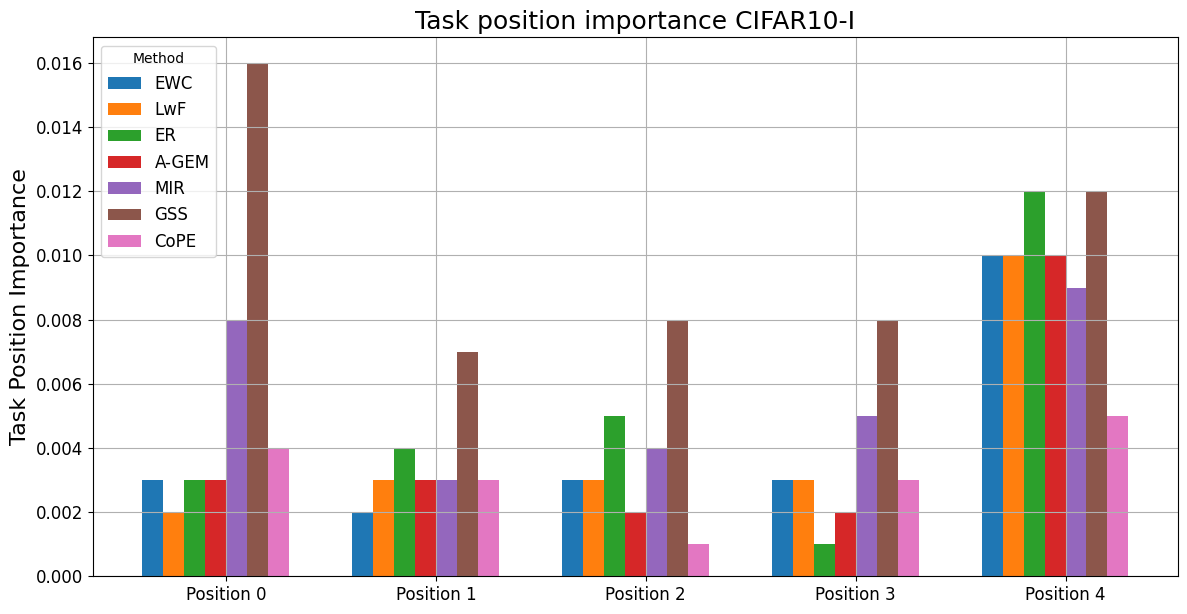

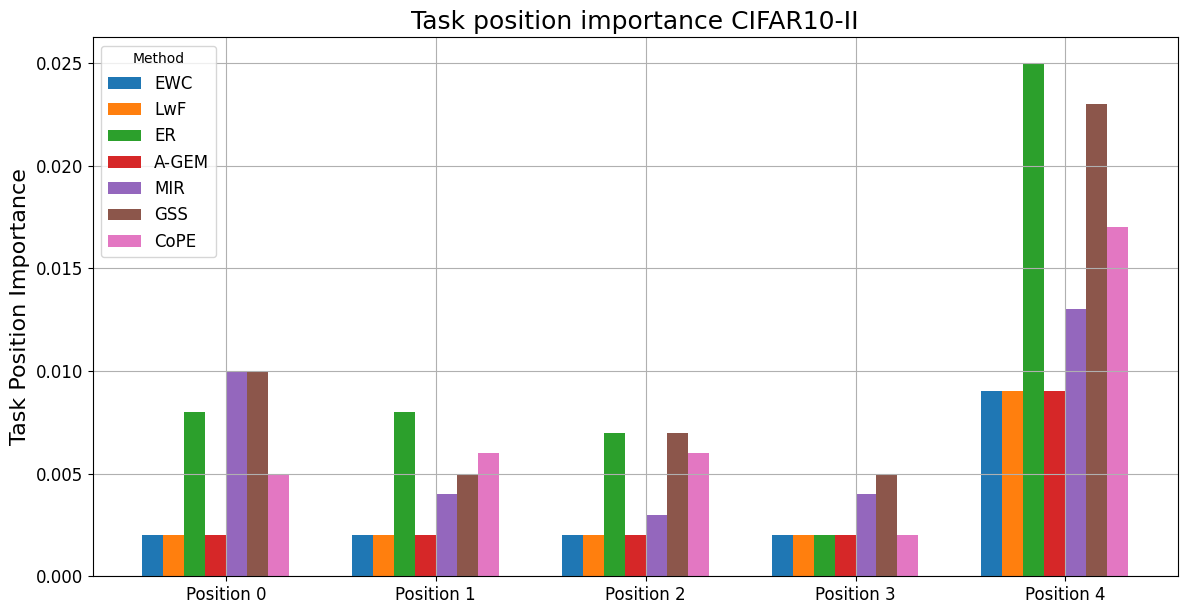

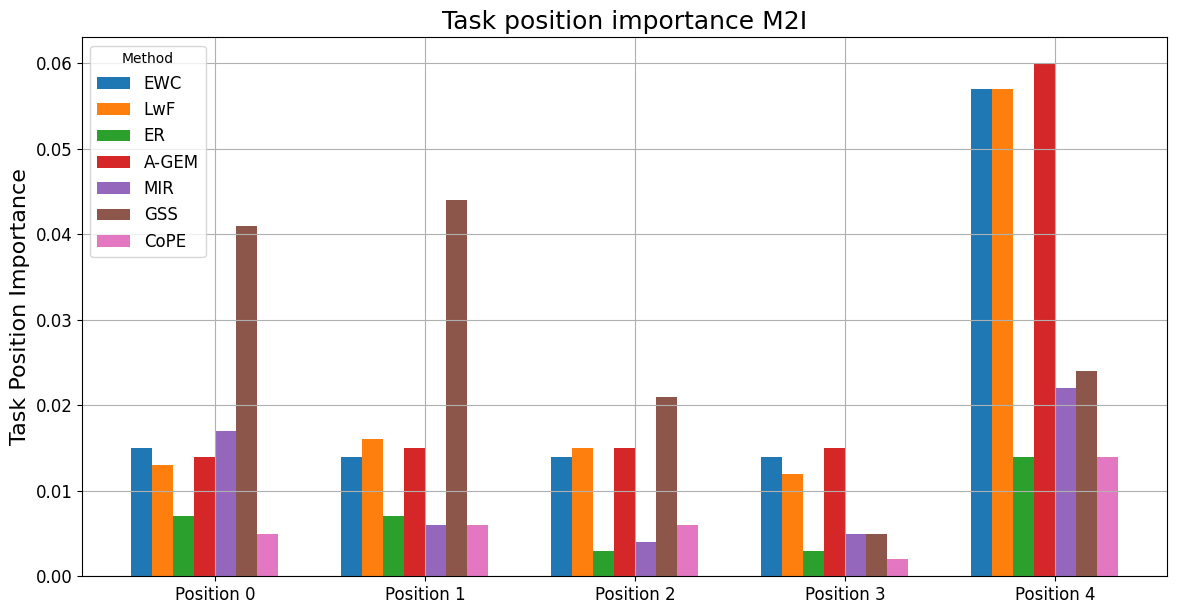

In [4]:
for dataset in datasets:
    # Load the data from the CSV file
    data = pd.read_csv(f"results/analysis/task_position_importance/task_position_importance_{dataset}.csv")

    # Extract positions and methods
    positions = data.columns[1:]  # All columns except the first one
    methods = [strategy_to_name[strat] for strat in data['Strategy']]

    # Extract the values
    values = data.iloc[:, 1:].values  # All rows and all columns except the first one

    # Convert the list to a numpy array for easier handling (optional here since it's already a numpy array)
    values = np.array(values)

    # Plot 2: Grouped Bar Plot
    plt.figure(figsize=(14, 7))

    bar_width = 0.1
    x = np.arange(len(positions))

    # Plotting bars for each method
    for i, method in enumerate(methods):
        plt.bar(x + i * bar_width, values[i], width=bar_width, label=method)

    plt.title(f'Task position importance {dataset_to_name[dataset]}', fontsize=18)
    plt.ylabel('Task Position Importance', fontsize=16)
    plt.xticks(x + bar_width * (len(methods) / 2), positions, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Method", fontsize=12)
    plt.grid()
    plt.savefig(f"results/analysis/task_position_importance/task_position_importance_{dataset}.png")

### Performance per position

In [5]:
performance_per_position_datasets = ["CIFAR10", "CIFAR10-random", "M2I"]
for dataset in performance_per_position_datasets:
    df_data = []
    for strategy in strategies:
        data_row = {"Strategy": strategy}
        acc_per_task_dict = load_oracle_results(dataset=dataset, strategy=strategy, metric="accuracy_per_task")
        acc_per_pos_list = []
        for key in acc_per_task_dict.keys():
            accuracy_per_task = acc_per_task_dict[key]
            ordering = list(ast.literal_eval(key))
            acc_per_pos_list.append([accuracy_per_task[i] for i in ordering])
        per_pos_avg_accuracy = np.mean(acc_per_pos_list, axis=0)
        for position_id, acc_value in enumerate(per_pos_avg_accuracy):
            data_row[f"Position {position_id}"] = acc_value
        df_data.append(data_row)
    df_performance_per_position = pd.DataFrame(df_data).round(3)
    df_performance_per_position.to_csv(f"results/analysis/task_position_importance/performance_per_position_{dataset}.csv", index=False)

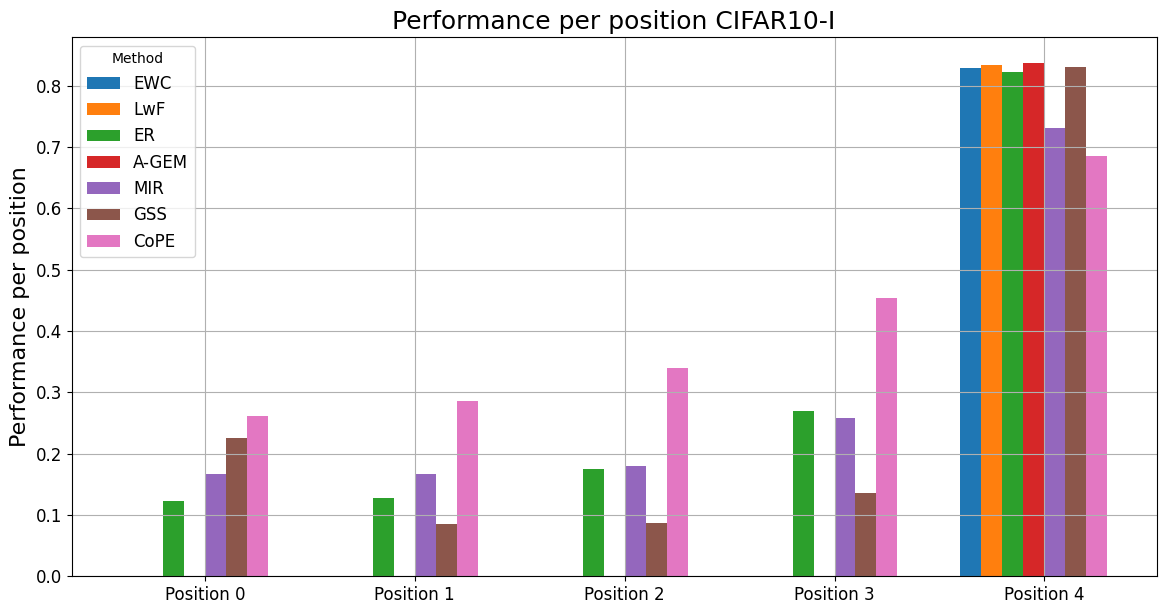

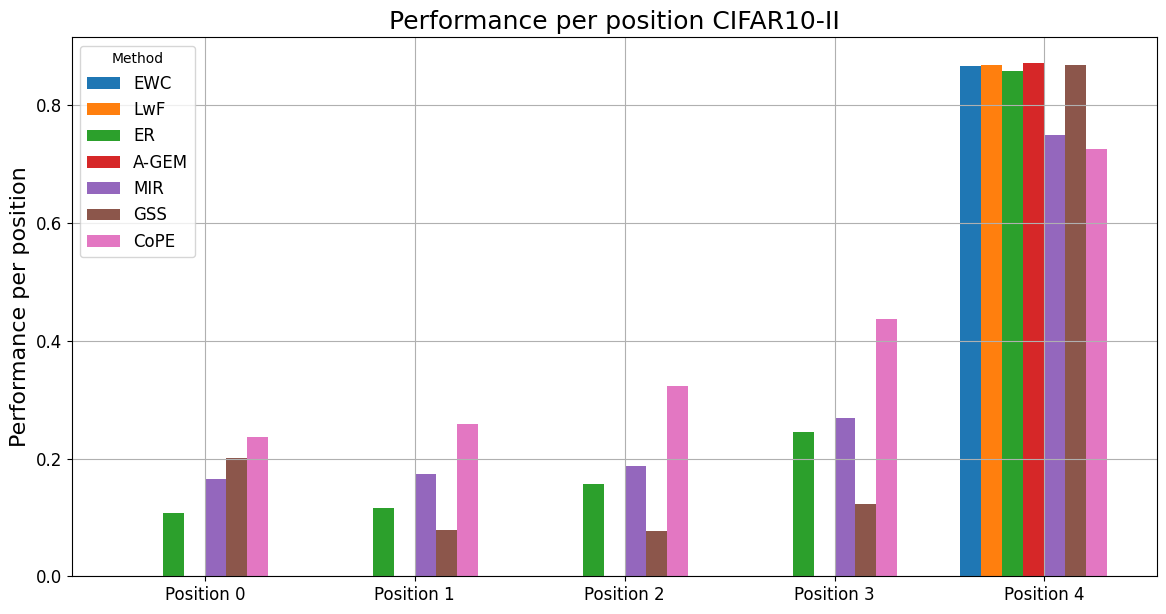

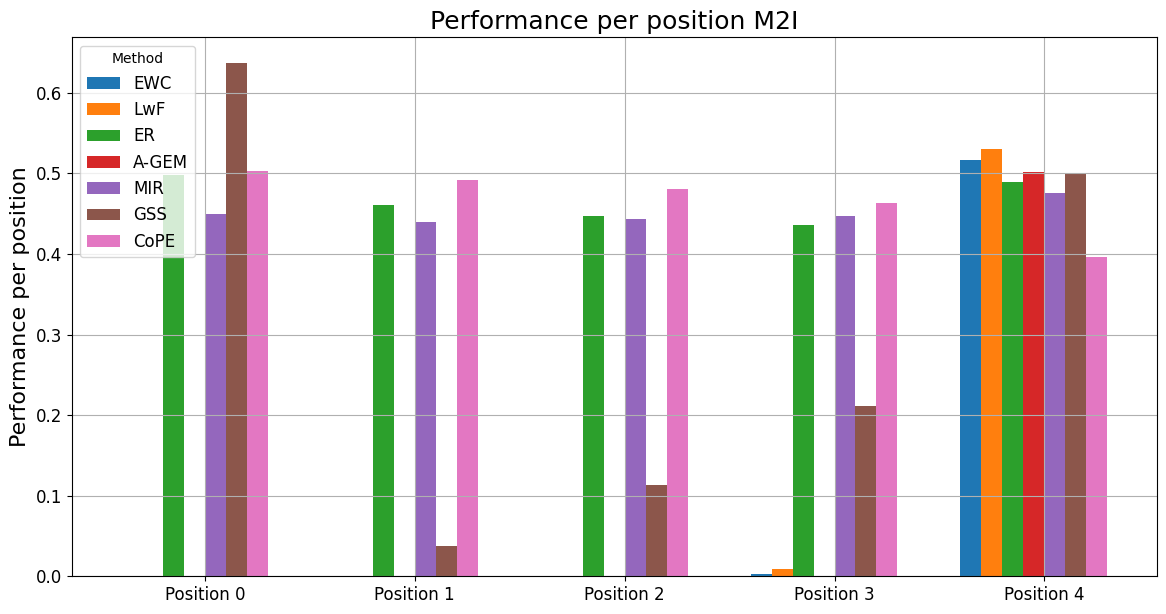

In [6]:
for dataset in datasets:
    # Load the data from the CSV file
    data = pd.read_csv(f"results/analysis/task_position_importance/performance_per_position_{dataset}.csv")

    # Extract positions and methods
    positions = data.columns[1:]  # All columns except the first one
    methods = [strategy_to_name[strat] for strat in data['Strategy']]
    
    # Extract the values
    values = data.iloc[:, 1:].values  # All rows and all columns except the first one

    # Convert the list to a numpy array for easier handling (optional here since it's already a numpy array)
    values = np.array(values)

    # Plot 2: Grouped Bar Plot
    plt.figure(figsize=(14, 7))

    bar_width = 0.1
    x = np.arange(len(positions))

    # Plotting bars for each method
    for i, method in enumerate(methods):
        plt.bar(x + i * bar_width, values[i], width=bar_width, label=method)

    plt.title(f'Performance per position {dataset_to_name[dataset]}', fontsize=18)
    plt.ylabel('Performance per position', fontsize=16)
    plt.xticks(x + bar_width * (len(methods) / 2), positions, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Method", fontsize=12)
    plt.grid()
    plt.savefig(f"results/analysis/task_position_importance/performance_per_position_{dataset}.png")

## 2. In which settings does task order affect the performance?
The results of this experiment can be found under results/analysis/effect_task_order

In [7]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        count = 0
        count_significant = 0
        p_values = dict()

        acc_dict = load_oracle_results(dataset, strategy, "accuracy")
        std_dict = load_oracle_results(dataset, strategy, "accuracy_std")
        
        best_perm = max(acc_dict, key=acc_dict.get)
        best_perm_value = acc_dict[best_perm] 
        best_perm_std = convert_to_ddof_1(std_dict[best_perm])

        for key in acc_dict.keys():
            if key != best_perm:
                permutation_value = acc_dict[key]
                permutation_std = convert_to_ddof_1(std_dict[key], sample_size=3)
                t_statistic, p_value = one_sided_t_test(best_perm_value, permutation_value, best_perm_std, permutation_std, n=3)
                if p_value < 0.05:
                    count_significant += 1
                count += 1        
        df_data.append({"Dataset": dataset, "Strategy": strategy, "Count significant": count_significant,  "Fraction significant" : count_significant/count})
df = pd.DataFrame(df_data).round(3)
df.to_csv("results/analysis/effect_task_order/best_vs_rest.csv", index=False)

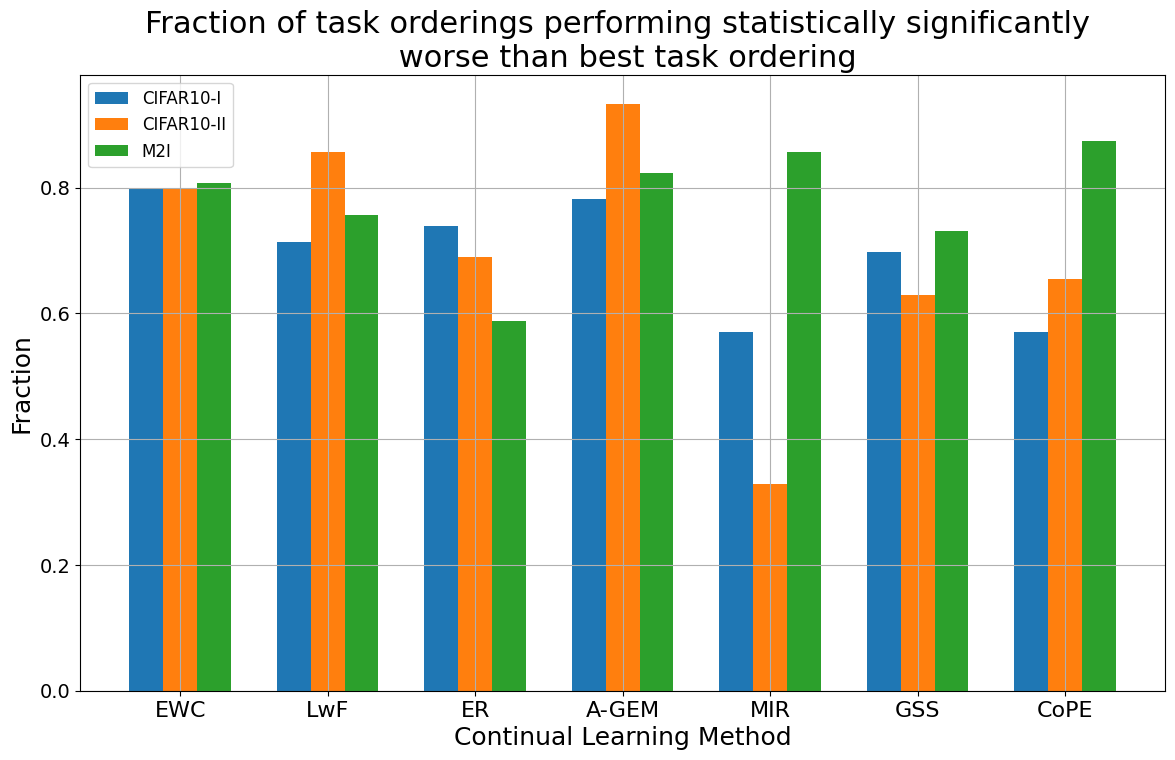

In [25]:
# Load the data from CSV
data = pd.read_csv('results/analysis/effect_task_order/best_vs_rest.csv')

# Extract unique strategies and datasets
strategies_unique = data['Strategy'].unique()
datasets_unique = data['Dataset'].unique()

# Define plot parameters
bar_width = 0.35
group_gap = 1.5 * bar_width  # The gap between groups

# Set the positions for the bars, including the gap
index_with_gap = np.arange(0, len(strategies_unique) * (1 + group_gap), 1 + group_gap)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

for i, dataset in enumerate(datasets_unique):
    # Filter the data for each dataset
    dataset_fractions = data[data['Dataset'] == dataset]['Fraction significant'].values
    
    # Plot the bars with adjusted positions
    ax.bar(index_with_gap + i * bar_width, dataset_fractions, bar_width, label=dataset_to_name[dataset])

# Labels and title
ax.set_xlabel('Continual Learning Method', fontsize=18)
ax.set_ylabel('Fraction', fontsize=18)
ax.set_title('Fraction of task orderings performing statistically significantly \n worse than the best task ordering', fontsize=22)
ax.set_xticks(index_with_gap + bar_width * (len(datasets_unique) - 1) / 2)
ax.set_xticklabels([strategy_to_name[strat] for strat in strategies_unique], fontsize=16)
ax.legend(fontsize=14)
plt.yticks(fontsize=14)
# Show the plot
plt.grid()
plt.show()

Here we compute the fractions grouped per last task

In [ ]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        df_entry = {"Dataset": dataset, "Strategy": strategy}
        for last_task in range(5):
            count = 0
            count_significant = 0
            p_values = dict()

            acc_dict = load_oracle_results(dataset, strategy, "accuracy")
            std_dict = load_oracle_results(dataset, strategy, "accuracy_std")
            keys = list(acc_dict.keys())
            for key in keys:
                ordering = ast.literal_eval(key)
                if ordering[-1] != last_task:
                    del acc_dict[key]
                    del std_dict[key]
            
            best_perm = max(acc_dict, key=acc_dict.get)
            best_perm_value = acc_dict[best_perm] 
            best_perm_std = convert_to_ddof_1(std_dict[best_perm])

            for key in acc_dict.keys():
                if key != best_perm:
                    permutation_value = acc_dict[key]
                    permutation_std = convert_to_ddof_1(std_dict[key], sample_size=3)
                    t_statistic, p_value = one_sided_t_test(best_perm_value, permutation_value, best_perm_std, permutation_std, n=3)
                    if p_value < 0.05:
                        count_significant += 1
                    count += 1        
            df_entry[f"Fraction significant last task {last_task}"] = count_significant/count
        df_data.append(df_entry)
df = pd.DataFrame(df_data).round(3)
df.to_csv("results/analysis/effect_task_order/best_vs_rest_last_task.csv", index=False)

In [ ]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        df_entry = {"Dataset": dataset, "Strategy": strategy}
        for last_task in range(5):
            count = 0
            count_significant = 0
            p_values = dict()

            acc_dict = load_oracle_results(dataset, strategy, "accuracy")
            std_dict = load_oracle_results(dataset, strategy, "accuracy_std")
            keys = list(acc_dict.keys())
            for key in keys:
                ordering = ast.literal_eval(key)
                if ordering[-1] != last_task:
                    del acc_dict[key]
                    del std_dict[key]
            
            best_perm = max(acc_dict, key=acc_dict.get)
            best_perm_value = acc_dict[best_perm] 
            best_perm_std = convert_to_ddof_1(std_dict[best_perm])

            for key in acc_dict.keys():
                if key != best_perm:
                    permutation_value = acc_dict[key]
                    permutation_std = convert_to_ddof_1(std_dict[key], sample_size=3)
                    t_statistic, p_value = one_sided_t_test(best_perm_value, permutation_value, best_perm_std, permutation_std, n=3)
                    if p_value < 0.05:
                        count_significant += 1
                    count += 1        
            df_entry[f"Count significant last task {last_task}"] = count_significant
        df_data.append(df_entry)
df = pd.DataFrame(df_data).round(3)
df.to_csv("results/analysis/effect_task_order/best_vs_rest_last_task_count.csv", index=False)

Next we compute the averaged over all last tasks, for easier comparison with the non-last task variant

In [ ]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        for last_task in range(5):
            df_entry = {"Dataset": dataset, "Strategy": strategy}
            count = 0
            count_significant = 0
            p_values = dict()

            acc_dict = load_oracle_results(dataset, strategy, "accuracy")
            std_dict = load_oracle_results(dataset, strategy, "accuracy_std")
            keys = list(acc_dict.keys())
            for key in keys:
                ordering = ast.literal_eval(key)
                if ordering[-1] != last_task:
                    del acc_dict[key]
                    del std_dict[key]
            
            best_perm = max(acc_dict, key=acc_dict.get)
            best_perm_value = acc_dict[best_perm] 
            best_perm_std = convert_to_ddof_1(std_dict[best_perm])

            for key in acc_dict.keys():
                if key != best_perm:
                    permutation_value = acc_dict[key]
                    permutation_std = convert_to_ddof_1(std_dict[key], sample_size=3)
                    t_statistic, p_value = one_sided_t_test(best_perm_value, permutation_value, best_perm_std, permutation_std, n=3)
                    if p_value < 0.05:
                        count_significant += 1
                    count += 1        

            df_entry[f"Fraction significant"] = count_significant/count
            df_data.append(df_entry)
df = pd.DataFrame(df_data).round(3)
df.groupby(["Dataset", "Strategy"]).mean().round(3).to_csv("results/analysis/effect_task_order/best_vs_rest_last_task_averaged.csv")

In [ ]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        for last_task in range(5):
            df_entry = {"Dataset": dataset, "Strategy": strategy}
            count = 0
            count_significant = 0
            p_values = dict()

            acc_dict = load_oracle_results(dataset, strategy, "accuracy")
            std_dict = load_oracle_results(dataset, strategy, "accuracy_std")
            keys = list(acc_dict.keys())
            for key in keys:
                ordering = ast.literal_eval(key)
                if ordering[-1] != last_task:
                    del acc_dict[key]
                    del std_dict[key]
            
            best_perm = max(acc_dict, key=acc_dict.get)
            best_perm_value = acc_dict[best_perm] 
            best_perm_std = convert_to_ddof_1(std_dict[best_perm])

            for key in acc_dict.keys():
                if key != best_perm:
                    permutation_value = acc_dict[key]
                    permutation_std = convert_to_ddof_1(std_dict[key], sample_size=3)
                    t_statistic, p_value = one_sided_t_test(best_perm_value, permutation_value, best_perm_std, permutation_std, n=3)
                    if p_value < 0.05:
                        count_significant += 1
                    count += 1        

            df_entry[f"Count significant"] = count_significant
            df_data.append(df_entry)
df = pd.DataFrame(df_data).round(3)
df.groupby(["Dataset", "Strategy"]).sum().round(3).to_csv("results/analysis/effect_task_order/best_vs_rest_last_task_averaged_count.csv")

## 3. Is the effect of task order caused by general patterns or very specific interactions between consecutive tasks?

The results of these experiments are stored under results/analysis/order_similarity_within_methods

In [ ]:
df_data = []
for dataset in datasets:
    for strategy in strategies:
        result_dict = load_oracle_results(dataset, strategy, "accuracy")
        top_keys_accuracy_strategy, _ = get_top(
                result_dict, x=120, descending=True
            )
        correlation_coefficient, p_value = rank_distance_correlation(top_keys_accuracy_strategy)
        df_data.append({"Dataset": dataset, "Strategy": strategy, "Correlation Coefficient": correlation_coefficient, "P-value": p_value})
df_within_methods = pd.DataFrame(df_data)
df_within_methods["P-value"] = df_within_methods["P-value"].apply(scientific_round)
df_within_methods["Correlation Coefficient"] = df_within_methods["Correlation Coefficient"].round(3)
df_within_methods.to_csv(f"results/analysis/order_similarity_within_methods/agreement_within_methods_full.csv", index=False)

In [ ]:
df_data = []
df_significant_data = []
for dataset in datasets:
    for strategy in strategies:
        df_entry = {"Dataset": dataset, "Strategy": strategy}
        df_significant_entry = {"Dataset": dataset, "Strategy": strategy}
        for last_task in range(5):
            acc_dict = load_oracle_results(dataset, strategy, "accuracy")
            items = list(acc_dict.items())
            for key, value in items:
                ordering = ast.literal_eval(key)
                if ordering[-1] != last_task:
                    del acc_dict[key]
            top_keys_accuracy_strategy, _ = get_top(
                acc_dict, x=len(acc_dict), descending=True
            )
            correlation_coefficient, p_value = rank_distance_correlation(top_keys_accuracy_strategy)
            df_entry[f"Last task {last_task}"] = correlation_coefficient
            if p_value < 0.05:
                df_significant_entry[f"Last task: {last_task}"] = p_value
        df_data.append(df_entry)
        df_significant_data.append(df_significant_entry)
df_within_methods_per_last_task = pd.DataFrame(df_data).round(3)
df_within_methods_per_last_task_significant = pd.DataFrame(df_significant_data)
df_within_methods_per_last_task_significant.to_csv("results/analysis/order_similarity_within_methods/agreement_within_methods_last_task_significant.csv", index=False)
df_within_methods_per_last_task.to_csv("results/analysis/order_similarity_within_methods/agreement_within_methods_last_task.csv", index=False)

## 4. Do different continual learning methods benefit from the same task orders?

The results of these experiments are stored under results/analysis/task_order_agreement_between_methods

In [ ]:
from itertools import permutations
orderings = list(permutations(range(5)))

for dataset in datasets:
    df_data = []
    for strategy1 in strategies:
        for strategy2 in strategies:
            result_dict_strategy1 = load_oracle_results(dataset, strategy1, "accuracy")
            result_dict_strategy2 = load_oracle_results(dataset, strategy2, "accuracy")

            ranks_strategy1 = [get_rank(result_dict_strategy1, str(tuple(permutation)), descending=True) for permutation in orderings] 
            ranks_strategy2 = [get_rank(result_dict_strategy2, str(tuple(permutation)), descending=True) for permutation in orderings]
            correlation_coefficient, p_value = spearmanr(ranks_strategy1, ranks_strategy2)
            df_data.append({"Dataset": dataset, "Strategy 1": strategy1, "Strategy 2": strategy2, "Correlation coefficient": correlation_coefficient,"P-value":p_value})
    df_agreement_between_methods = pd.DataFrame(df_data)
    df_agreement_between_corr = df_agreement_between_methods.drop(["Dataset"], axis=1).pivot_table(index='Strategy 1', columns='Strategy 2', values='Correlation coefficient')
    df_agreement_between_p = df_agreement_between_methods.drop(["Dataset"], axis=1).pivot_table(index='Strategy 1', columns='Strategy 2', values='P-value')

    df_agreement_between_corr[strategies].reindex(strategies).round(3).to_csv(f"results/analysis/task_order_agreement_between_methods/{dataset}_between_methods_corr-coef.csv")
    df_agreement_between_p[strategies].reindex(strategies).round(3).to_csv(f"results/analysis/task_order_agreement_between_methods/{dataset}_between_methods_p-value.csv")

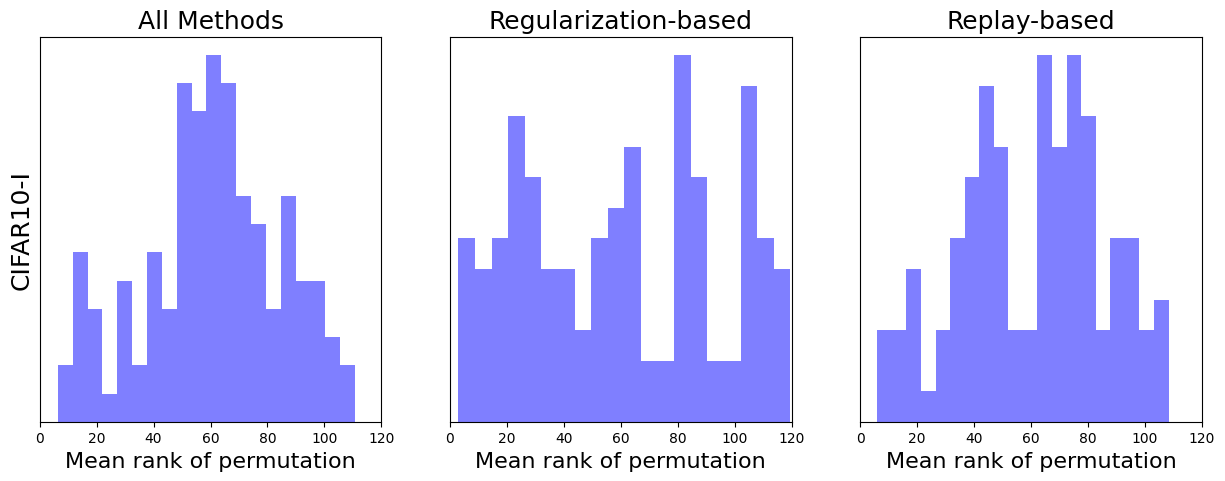

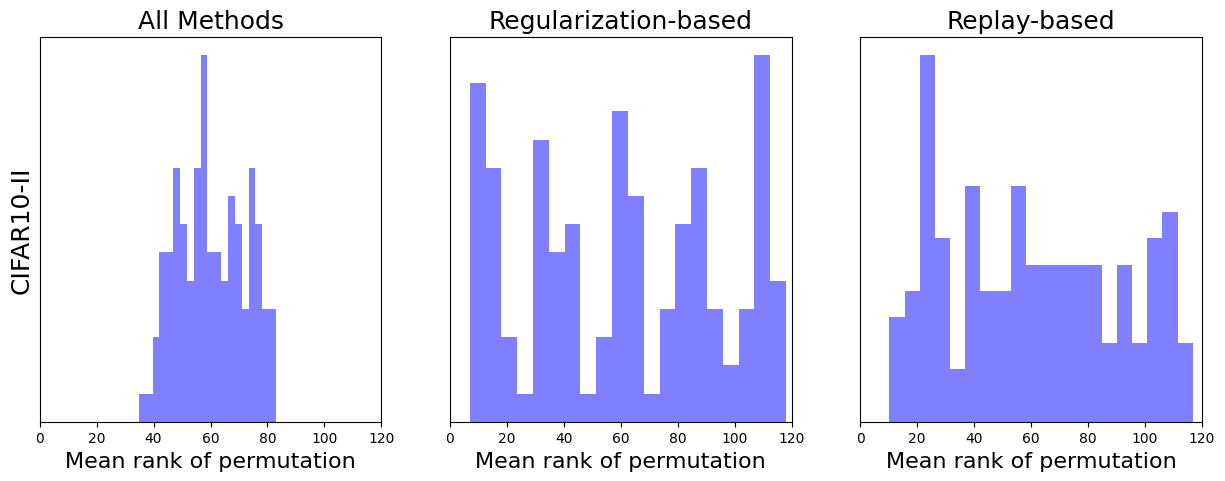

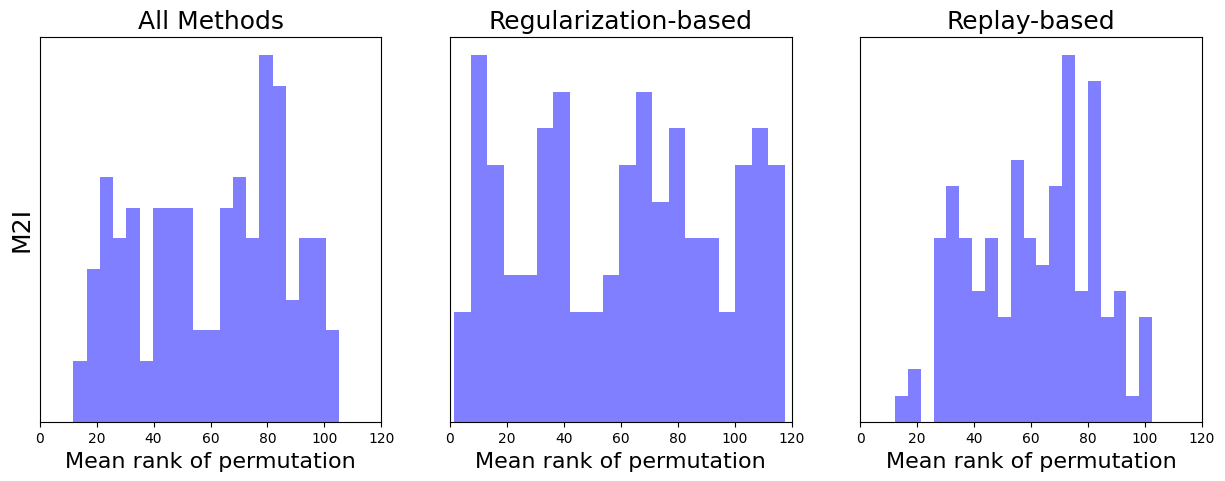

In [ ]:
for idx, dataset in enumerate(datasets):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_ylabel(dataset_to_name[dataset], fontsize=18)
    _, df_permutation_ranks = average_score_permutations(dataset=dataset, strategies=strategies)
    average_ranks = df_permutation_ranks["Mean Accuracy Rank"]
    axs[0].hist(average_ranks, bins=20, density=True, alpha=0.5, color='b')
    axs[0].set_xlim(0, 120)
    axs[0].set_xlabel('Mean rank of permutation', fontsize=16)
    axs[0].set_title("All Methods", fontsize=18)
    axs[0].set_yticks([])

    average_ranks_regularization = pd.DataFrame(df_permutation_ranks[regularization_based_strategies].mean(axis=1))
    axs[1].hist(average_ranks_regularization, bins=20, density=True, alpha=0.5, color='b')
    axs[1].set_xlim(0, 120)
    axs[1].set_xlabel('Mean rank of permutation', fontsize=16)
    axs[1].set_yticks([])
    axs[1].set_title("Regularization-based", fontsize=18)

    average_ranks_replay = pd.DataFrame(df_permutation_ranks[replay_based_strategies].mean(axis=1))
    axs[2].hist(average_ranks_replay, bins=20, density=True, alpha=0.5, color='b')
    axs[2].set_xlim(0, 120)
    axs[2].set_xlabel('Mean rank of permutation', fontsize=16)
    axs[2].set_yticks([])
    axs[2].set_title("Replay-based", fontsize=18)
    plt.savefig(f"results/analysis/task_order_agreement_between_methods/{dataset}_distribution_mean_ranks.png")
    plt.show()

## 6. What characterizes task orders that lead to high performance?

For the per-task training, joint-training and TSNE plots please refer to the file joint_training.py, the results are stored in results/analysis/characteristics_good_bad_orders

### CIFAR10-I

In [ ]:
df_permutation_scores, df_permutation_ranks = average_score_permutations("CIFAR10", replay_based_strategies)
best5_acc = df_permutation_scores.head(5)
best5_rank = df_permutation_ranks.loc[best5_acc.index]
worst5_acc = df_permutation_scores.tail(5)
worst5_rank = df_permutation_ranks.loc[worst5_acc.index]

In [ ]:
best5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-I/best5_acc.csv")
best5_rank.to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-I/best5_rank.csv")
worst5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-I/worst5_acc.csv")
worst5_rank.to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-I/worst5_rank.csv")

In [ ]:
df_permutation_scores['Last Element'] = df_permutation_scores.index.map(lambda x: int(x.strip('()').split(',')[-1]))
average_mean_accuracy = df_permutation_scores.groupby('Last Element')['Mean Accuracy'].mean().reset_index()
average_mean_accuracy.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-I/last_task_performance.csv", index=False)

0.30692727251055374,  0.0006503118462846651


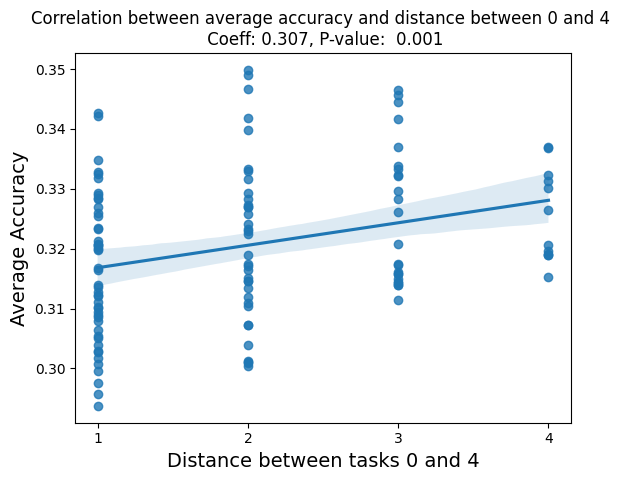

In [ ]:
rank = []
diff_0_4 = []
for index, row in df_permutation_scores.iterrows():
    permutation = list(ast.literal_eval(index))
    rank.append(row["Mean Accuracy"])
    diff_0_4.append(distance_between_elements(permutation, 0, 4))

sns.regplot(x=diff_0_4, y=rank, scatter=True)
correlation_coefficient, p_value = spearmanr(rank, diff_0_4)
print(f"{correlation_coefficient},  {p_value}")
plt.title(
    f"Correlation between average accuracy and distance between 0 and 4 \n Coeff: {round(correlation_coefficient, 3) }, P-value:  {round(p_value, 3)}"
)
plt.xlabel("Distance between tasks 0 and 4", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.xticks([1, 2, 3, 4])
plt.savefig("results/analysis/characteristics_good_bad_orders/CIFAR10-I/distance_0_4_acc_correlation.png")
plt.show()


### CIFAR10-II

In [ ]:
df_permutation_scores, df_permutation_ranks = average_score_permutations("CIFAR10-random", replay_based_strategies)
best5_acc = df_permutation_scores.head(5)
best5_rank = df_permutation_ranks.loc[best5_acc.index]
worst5_acc = df_permutation_scores.tail(5)
worst5_rank = df_permutation_ranks.loc[worst5_acc.index]

In [ ]:
best5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-II/best5_acc.csv")
best5_rank.to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-II/best5_rank.csv")
worst5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-II/worst5_acc.csv")
worst5_rank.to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-II/worst5_rank.csv")

In [ ]:
df_permutation_scores['Last Element'] = df_permutation_scores.index.map(lambda x: int(x.strip('()').split(',')[-1]))
average_mean_accuracy = df_permutation_scores.groupby('Last Element')['Mean Accuracy'].mean().reset_index()
average_mean_accuracy.round(3).to_csv("results/analysis/characteristics_good_bad_orders/CIFAR10-II/last_task_performance.csv", index=False)

### M2I

In [ ]:
df_permutation_scores, df_permutation_ranks = average_score_permutations("M2I", replay_based_strategies)
best5_acc = df_permutation_scores.head(5)
best5_rank = df_permutation_ranks.loc[best5_acc.index]
worst5_acc = df_permutation_scores.tail(5)
worst5_rank = df_permutation_ranks.loc[worst5_acc.index]

In [ ]:
best5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/M2I/best5_acc.csv")
best5_rank.to_csv("results/analysis/characteristics_good_bad_orders/M2I/best5_rank.csv")
worst5_acc.round(3).to_csv("results/analysis/characteristics_good_bad_orders/M2I/worst5_acc.csv")
worst5_rank.to_csv("results/analysis/characteristics_good_bad_orders/M2I/worst5_rank.csv")

In [ ]:
df_permutation_scores['Last Element'] = df_permutation_scores.index.map(lambda x: int(x.strip('()').split(',')[-1]))
average_mean_accuracy = df_permutation_scores.groupby('Last Element')['Mean Accuracy'].mean().reset_index()
average_mean_accuracy.round(3).to_csv("results/analysis/characteristics_good_bad_orders/M2I/last_task_performance.csv", index=False)

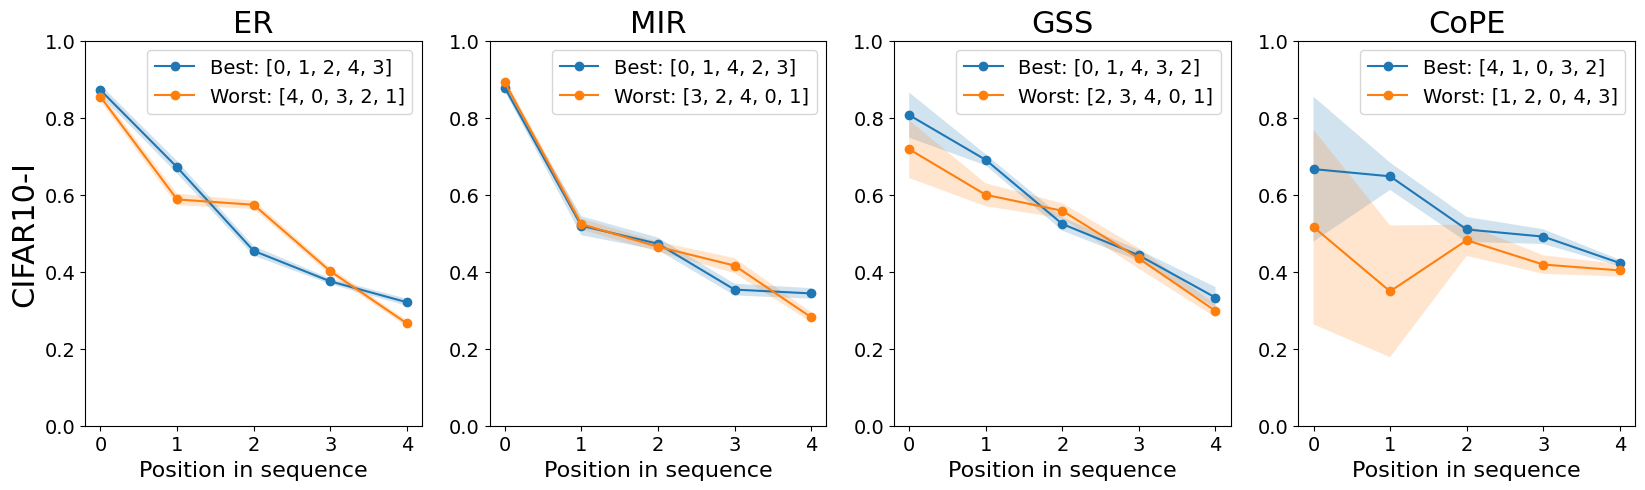

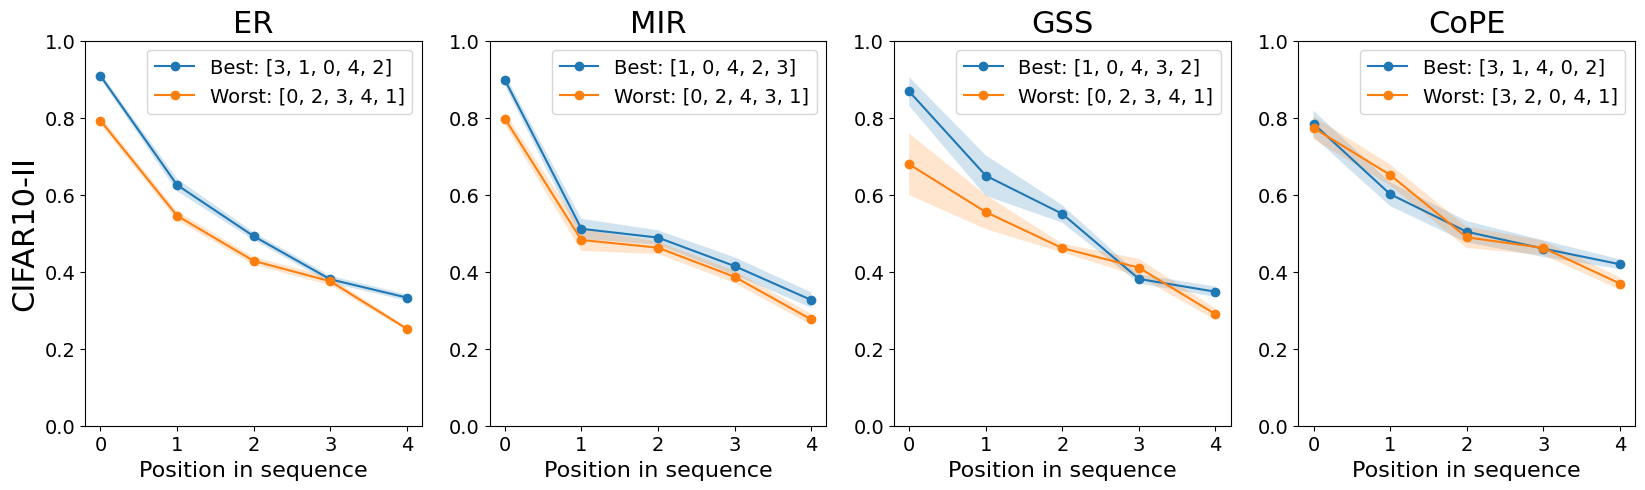

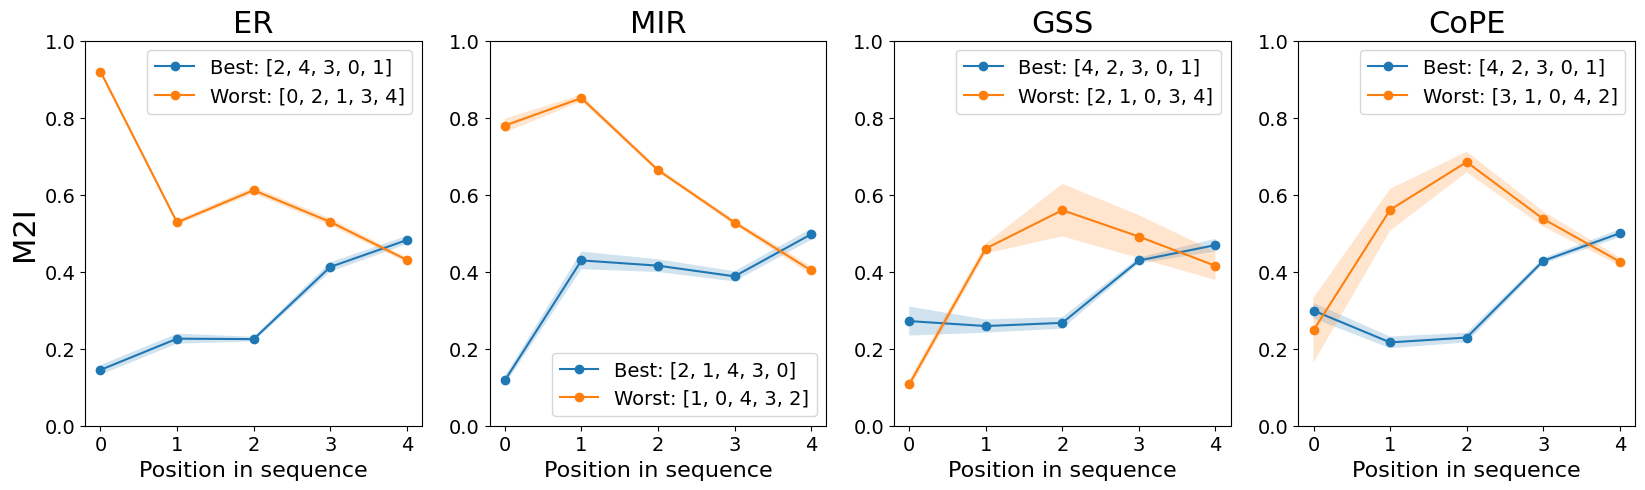

In [ ]:
for dataset in datasets:
    fig, axs = plt.subplots(1, len(replay_based_strategies), figsize=(5*len(replay_based_strategies), 5))
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=14)
    for col_idx, strategy in enumerate(replay_based_strategies):
        axs[col_idx].set_title(strategy_to_name[strategy], fontsize=22)
        if col_idx == 0: 
            axs[col_idx].set_ylabel(dataset_to_name[dataset], fontsize=22)
        axs[col_idx].set_xlabel("Position in sequence", fontsize=16)

        best_perm_results = load_results_performance_over_sequence(dataset, strategy, classification="best")
        worst_perm_results = load_results_performance_over_sequence(dataset, strategy, classification="worst")

        mean_best = np.mean(best_perm_results["accuracy"], axis=0)
        std_best = np.std(best_perm_results["accuracy"], axis=0)
        mean_worst = np.mean(worst_perm_results["accuracy"], axis=0)
        std_worst = np.std(worst_perm_results["accuracy"], axis=0)

        axs[col_idx].plot(mean_best, marker="o")
        axs[col_idx].plot(mean_worst, marker="o")
        
        axs[col_idx].fill_between(
            x=np.arange(5), y1=mean_best - std_best, y2=mean_best + std_best, alpha=0.2
        )
        axs[col_idx].fill_between(
            x=np.arange(5), y1=mean_worst - std_worst, y2=mean_worst + std_worst, alpha=0.2
        )
        
        axs[col_idx].set_ylim((0, 1))
        # axs[col_idx].set_xticks(fontsize=14)
        # axs[col_idx].set_yticks(fontsize=14)
        best_perm_order = best_perm_results["ordering"][0]
        worst_perm_order = worst_perm_results["ordering"][0]
        axs[col_idx].legend([f"Best: {best_perm_order}", f"Worst: {worst_perm_order}"], fontsize=14)
    plt.savefig(f"results/analysis/characteristics_good_bad_orders/{dataset_to_name[dataset]}/performance_over_sequence.png")

CIFAR10
CIFAR10
CIFAR10
CIFAR10


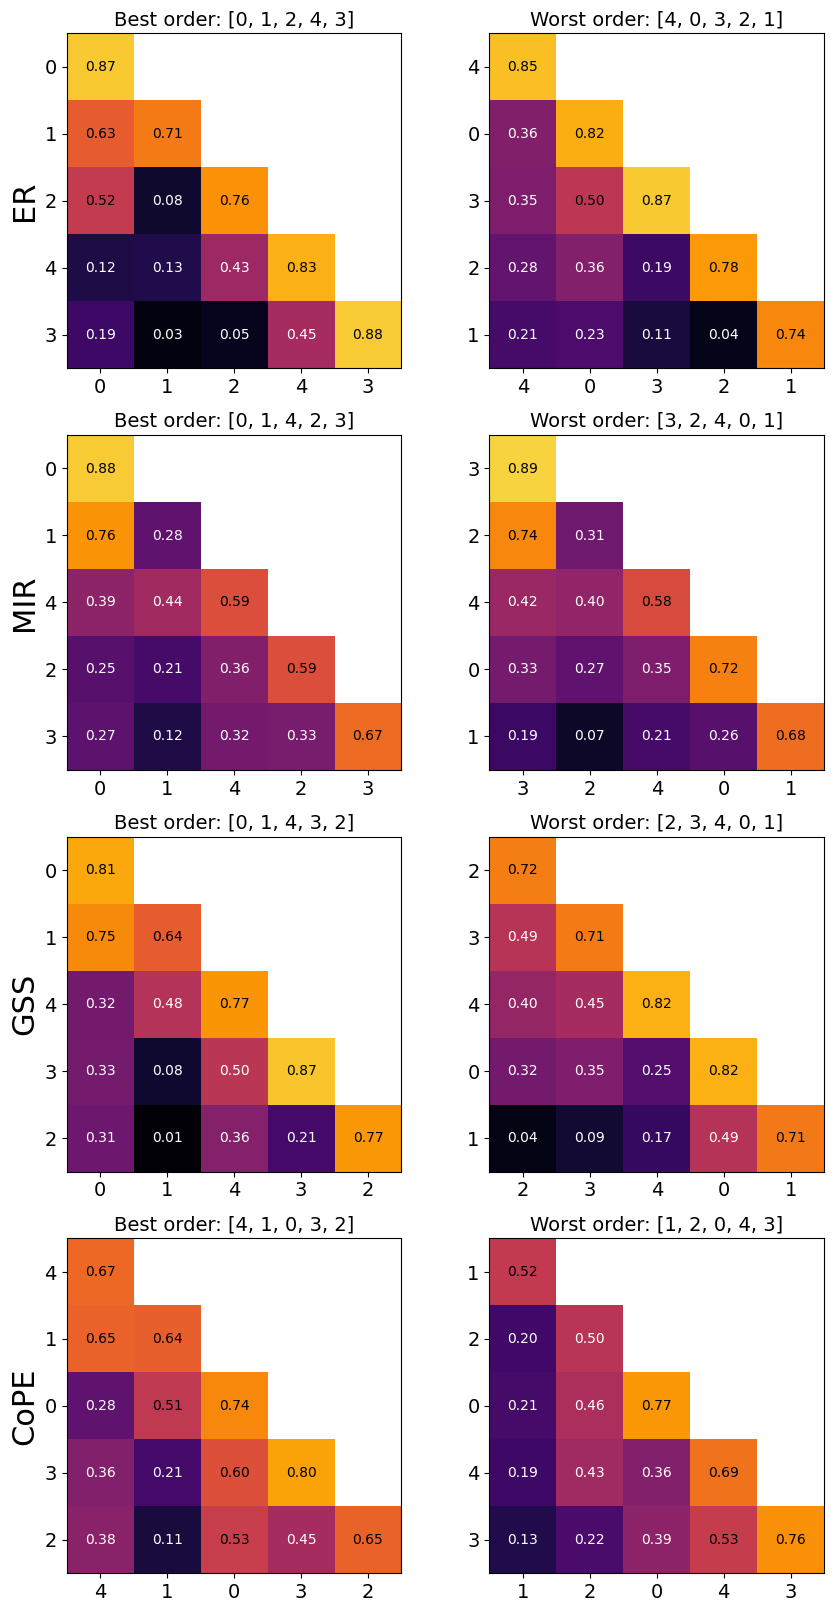

CIFAR10-random
CIFAR10-random
CIFAR10-random
CIFAR10-random


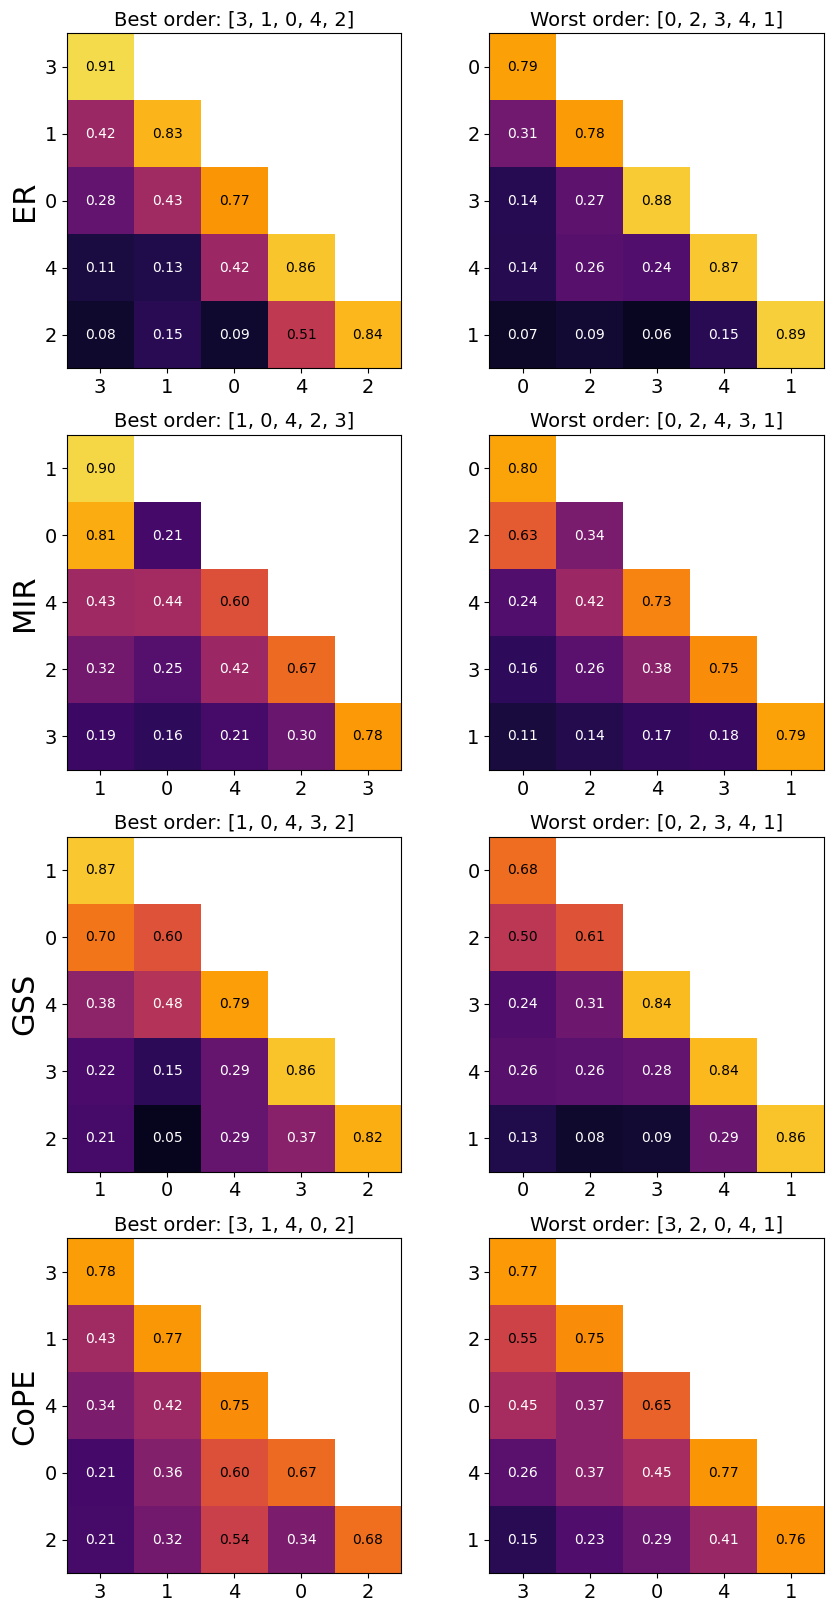

M2I
M2I
M2I
M2I


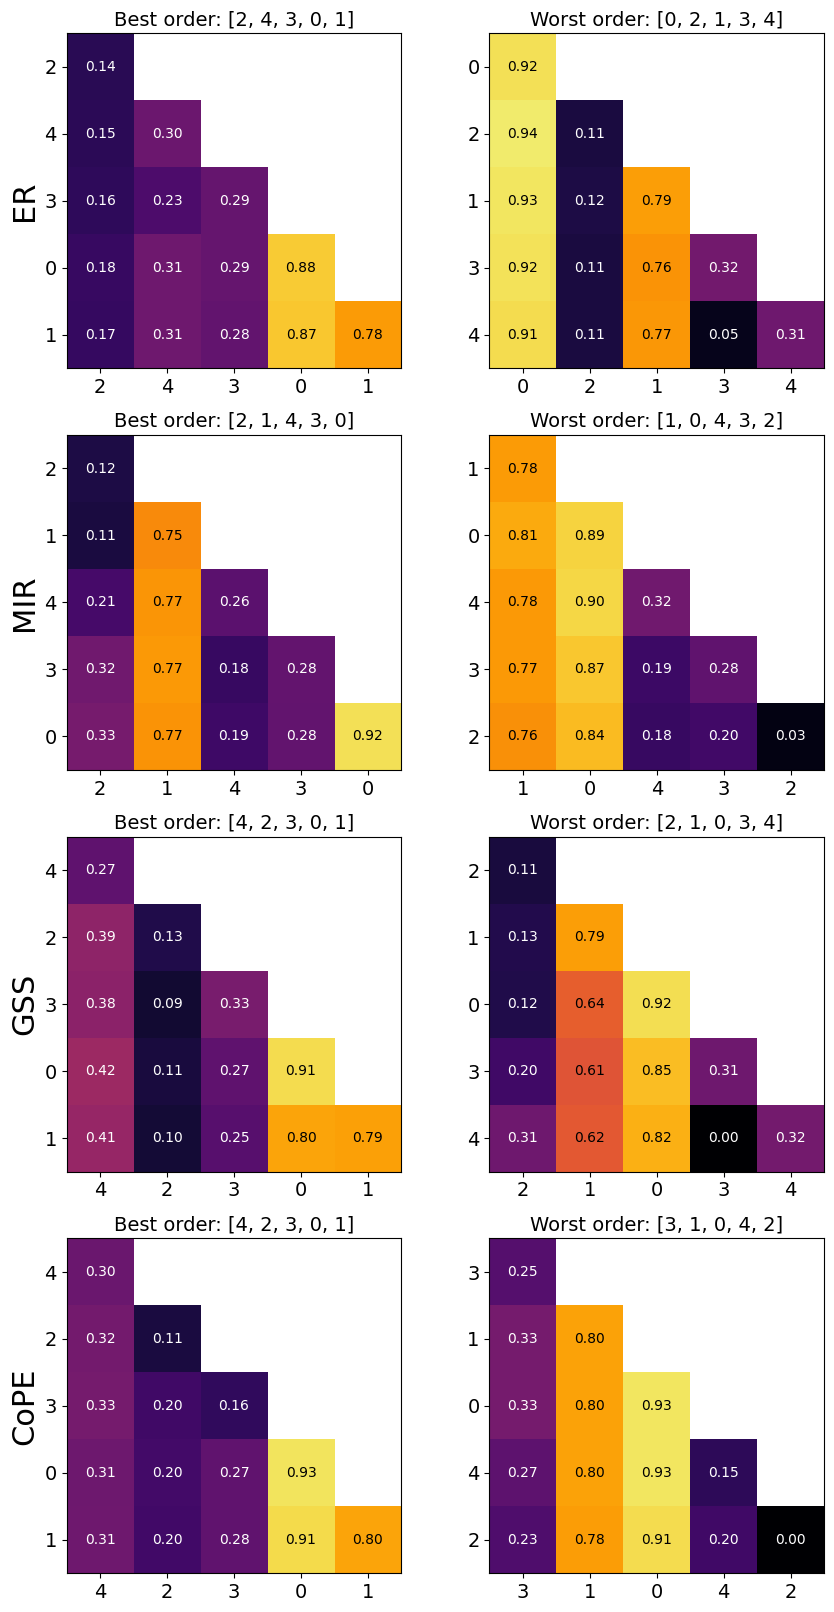

In [ ]:
for dataset in datasets:
    fig, axs = plt.subplots(len(replay_based_strategies), 2, figsize=(10, 20))
    # fig.suptitle(f"Per task average accuracy evolution for best and worst ordering {dataset}", fontsize=18)
    for row_idx, strategy in enumerate(replay_based_strategies):
        print(dataset)
        best_perm_results = load_results_performance_over_sequence(dataset, strategy, classification="best")
        best_perm_order = best_perm_results["ordering"][0]
        worst_perm_results = load_results_performance_over_sequence(dataset, strategy, classification="worst")
        worst_perm_order = worst_perm_results["ordering"][0]
        
        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        best_order_mean = np.mean(np.array(best_perm_results["accuracy per task"]), axis=0)
        best_order_mean[best_order_mean == -1] = None
        best_order_mean = best_order_mean[:, best_perm_order]
        axs[row_idx, 0].imshow(best_order_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 0].set_title(f"Best order: {best_perm_order}", fontsize=14)
        axs[row_idx, 0].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=22)
        axs[row_idx, 0].set_xticks(ticks=np.arange(5), labels=best_perm_order, fontsize=14)
        axs[row_idx, 0].set_yticks(ticks=np.arange(5), labels=best_perm_order, fontsize=14)
        # Add text annotations for each cell
        for i in range(best_order_mean.shape[0]):
            for j in range(best_order_mean.shape[1]):
                if best_order_mean[i, j] >= 0.5:
                    color = "black"
                else:
                    color = "white"
                axs[row_idx, 0].text(j, i, f'{best_order_mean[i, j]:.2f}', ha='center', va='center', color=color)

        worst_order_mean = np.mean(np.array(worst_perm_results["accuracy per task"]), axis=0)
        worst_order_mean[worst_order_mean == -1] = None
        worst_order_mean = worst_order_mean[:, worst_perm_order]
        axs[row_idx, 1].imshow(worst_order_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 1].set_title(f"Worst order: {worst_perm_order}", fontsize=14)
        axs[row_idx, 1].set_xticks(ticks=np.arange(5), labels=worst_perm_order, fontsize=14)
        axs[row_idx, 1].set_yticks(ticks=np.arange(5), labels=worst_perm_order, fontsize=14)
        # Add text annotations for each cell
        for i in range(worst_order_mean.shape[0]):
            for j in range(worst_order_mean.shape[1]):
                if worst_order_mean[i, j] >= 0.5:
                    color = "black"
                else:
                    color = "white"
                axs[row_idx, 1].text(j, i, f'{worst_order_mean[i, j]:.2f}', ha='center', va='center', color=color)
    plt.savefig(f"results/analysis/characteristics_good_bad_orders/{dataset_to_name[dataset]}/per_task_performance_over_sequence.png")
    plt.show()